In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

from pathlib import Path
import cv2
TARGET_HEIGHT = 224
TARGET_WIDTH = 320
from tg3k_eval import combined_segmentation_loss
from utils import load_image_as_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from pathlib import Path
import cv2

from tg3k_eval import combined_segmentation_loss
from utils import load_image_as_array

TARGET_HEIGHT = 224
TARGET_WIDTH = 320

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_top5_best_and_worst_samples(model, ds):
    all_sample_losses = []

    model.eval()
    with torch.no_grad():
        for idx in range(len(ds)):
            img, mask, meta = ds[idx]

            img_t = img.unsqueeze(0).to(device)
            mask_t = mask.unsqueeze(0).to(device)

            logits = model(img_t)
            loss = combined_segmentation_loss(logits, mask_t, lambda_dice=0.2)

            all_sample_losses.append(loss.item())

    all_sample_losses = np.array(all_sample_losses)
    sorted_indices = np.argsort(all_sample_losses)

    top_5_best_indices = sorted_indices[:5]
    top_5_worst_indices = sorted_indices[-5:][::-1]

    print("Indices of 5 best performing samples (lowest loss):", top_5_best_indices)
    print("Indices of 5 worst performing samples (highest loss):", top_5_worst_indices)

    print("\nLosses for 5 best samples:")
    for i, idx in enumerate(top_5_best_indices):
        print(f"Sample idx={idx}: Loss = {all_sample_losses[idx]:.4f}")

    print("\nLosses for 5 worst samples:")
    for i, idx in enumerate(top_5_worst_indices):
        print(f"Sample idx={idx}: Loss = {all_sample_losses[idx]:.4f}")

    return top_5_best_indices, top_5_worst_indices


def visualize_samples_in_one_plot(ds, model, sample_indices, title_prefix="top 5 best or worst sample visualizations"):
    resize_transform_only = A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH)

    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    fig.suptitle(title_prefix, fontsize=18)

    if num_samples == 1:
        axes = axes.reshape(1, 4)

    model.eval()
    for row, idx in enumerate(sample_indices):
        img_t, mask_t, meta = ds[idx]     
        img_path = Path(meta)

        original_img_np = load_image_as_array(img_path)
        resized_img = resize_transform_only(image=original_img_np)["image"]

        img_batch = img_t.unsqueeze(0).to(device)
        with torch.no_grad():
            probs = torch.sigmoid(model(img_batch))
            pred_mask_np = (probs > 0.5).float().squeeze().cpu().numpy()

        gt_mask_np = mask_t.squeeze().cpu().numpy()

        # overlay
        base_rgb = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
        red_mask = np.zeros_like(base_rgb)
        red_mask[pred_mask_np == 1] = [255, 0, 0]
        overlay = cv2.addWeighted(base_rgb, 1, red_mask, 0.5, 0)

        axes[row, 0].imshow(resized_img, cmap="gray")
        axes[row, 0].set_title(f"Sample idx={idx} Input")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(gt_mask_np, cmap="gray")
        axes[row, 1].set_title("Ground Truth")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(pred_mask_np, cmap="gray")
        axes[row, 2].set_title("Prediction")
        axes[row, 2].axis("off")

        axes[row, 3].imshow(overlay)
        axes[row, 3].set_title("Overlay")
        axes[row, 3].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


def get_saliency_map(img, mask, model):
    img = img.unsqueeze(0).to(device)
    img.requires_grad = True
    mask = mask.to(device)

    output = model(img)
    target = output[0].sum()
    target.backward()

    saliency = img.grad.abs().cpu()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(img.detach().cpu().squeeze(), cmap='gray')
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(saliency.detach().cpu().squeeze(), cmap='hot')
    ax[1].set_title("Saliency")
    ax[1].axis("off")

    ax[2].imshow(mask.detach().cpu().squeeze(), cmap='gray')
    ax[2].set_title("Mask")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


In [9]:
##
# This cell only used for loading pretrain checkpoint
##


import torch
from utils import create_unet_model   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# where to load checkpoint 
ckpt_path = "./tg3k/checkpoints_unet_mim/mim_best.pth"

ckpt = torch.load(ckpt_path, map_location=device)

cfg = ckpt["args"]   
print(cfg)          

model = create_unet_model(
    model_type=cfg["model_type"],        
    in_channels=1,
    out_channels=1,
    base_channels=cfg["base_channels"],
    bilinear=not cfg.get("no_bilinear", False),
    device=device,
)

model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

model


{'images_dir': '.\\tg3k\\tg3k\\thyroid-image', 'checkpoint_dir': '.\\tg3k\\checkpoints_unet_mim', 'log_dir': '.\\tg3k\\runs\\mim_tg3k_unet', 'split_json': '.\\tg3k\\tg3k\\tg3k-trainval.json', 'model_type': 'unet', 'img_height': 224, 'img_width': 320, 'batch_size': 4, 'epochs': 50, 'num_workers': 0, 'lr': 0.0001, 'weight_decay': 5e-05, 'base_channels': 32, 'no_bilinear': False, 'mask_ratio': 0.55, 'min_block_size': 32, 'max_block_size': 96, 'seed': 42, 'cpu': False, 'resume': None, 'log_interval': 50}
Using standard UNet2D ...


UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [35]:
##
# This cell only used for loading finetune checkpoint
##


import torch
from tg3k_finetune_segementation import create_unet_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_unet_model(
    model_type="unet",
    in_channels=1,
    out_channels=1,
    base_channels=32,
    bilinear=True,
    device=device,
)

# ckpt_path = "./tg3k/checkpoints_finetune/mim_unet/best_model.pth"
ckpt_path = "./tg3k/checkpoints_finetune/mim_unet/best_model.pth"

state_dict = torch.load(ckpt_path, map_location=device)

model.load_state_dict(state_dict)
model.to(device)
model.eval()

model

In [10]:

import os, json, random
from pathlib import Path

import torch

from tg3k_finetune_segementation import (
    ThyroidDataset,
    get_segmentation_val_transforms_split,
    set_seed,
)

images_dir = r"E:\Data\ToothSeg\tg3k\tg3k\thyroid-image"
masks_dir  = r"E:\Data\ToothSeg\tg3k\tg3k\thyroid-mask"
split_json = r"E:\Data\ToothSeg\tg3k\tg3k\tg3k-trainval.json"

seed = 42
set_seed(seed)

all_image_files = sorted(
    f for f in os.listdir(images_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
)

with open(split_json, "r") as f:
    split_data = json.load(f)

def get_files_from_ids(id_list, available_files):
    file_map = {os.path.splitext(f)[0]: f for f in available_files}
    res = []
    for i in id_list:
        try:
            base = f"{int(i):04d}"
        except Exception:
            base = str(i)
        if base in file_map:
            res.append(file_map[base])
    return res

train_files = get_files_from_ids(split_data["train"], all_image_files)
val_all_files = get_files_from_ids(split_data["val"], all_image_files)

random.seed(seed)
random.shuffle(val_all_files)
split_point = len(val_all_files) // 2
val_files = val_all_files[:split_point]
test_files = val_all_files[split_point:]

print(f"Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

val_common, val_img_tf, val_mask_tf = get_segmentation_val_transforms_split()

val_ds = ThyroidDataset(
    image_ids=val_files,
    images_dir=images_dir,
    masks_dir=masks_dir,
    common_transforms=val_common,
    image_transforms=val_img_tf,
    mask_transforms=val_mask_tf,
)

len(val_ds), val_ds[0][0].shape, val_ds[0][1].shape, val_ds[0][2]


Train=3226, Val=179, Test=180


(179,
 torch.Size([1, 224, 320]),
 torch.Size([1, 224, 320]),
 'E:\\Data\\ToothSeg\\tg3k\\tg3k\\thyroid-image\\3315.jpg')

In [11]:
best_indices, worst_indices = get_top5_best_and_worst_samples(model, val_ds)


Indices of 5 best performing samples (lowest loss): [161 150   8 121 135]
Indices of 5 worst performing samples (highest loss): [ 58 176  16  26  28]

Losses for 5 best samples:
Sample idx=161: Loss = 1.0773
Sample idx=150: Loss = 1.0790
Sample idx=8: Loss = 1.0791
Sample idx=121: Loss = 1.0792
Sample idx=135: Loss = 1.0793

Losses for 5 worst samples:
Sample idx=58: Loss = 1.2993
Sample idx=176: Loss = 1.2970
Sample idx=16: Loss = 1.2884
Sample idx=26: Loss = 1.2657
Sample idx=28: Loss = 1.2651


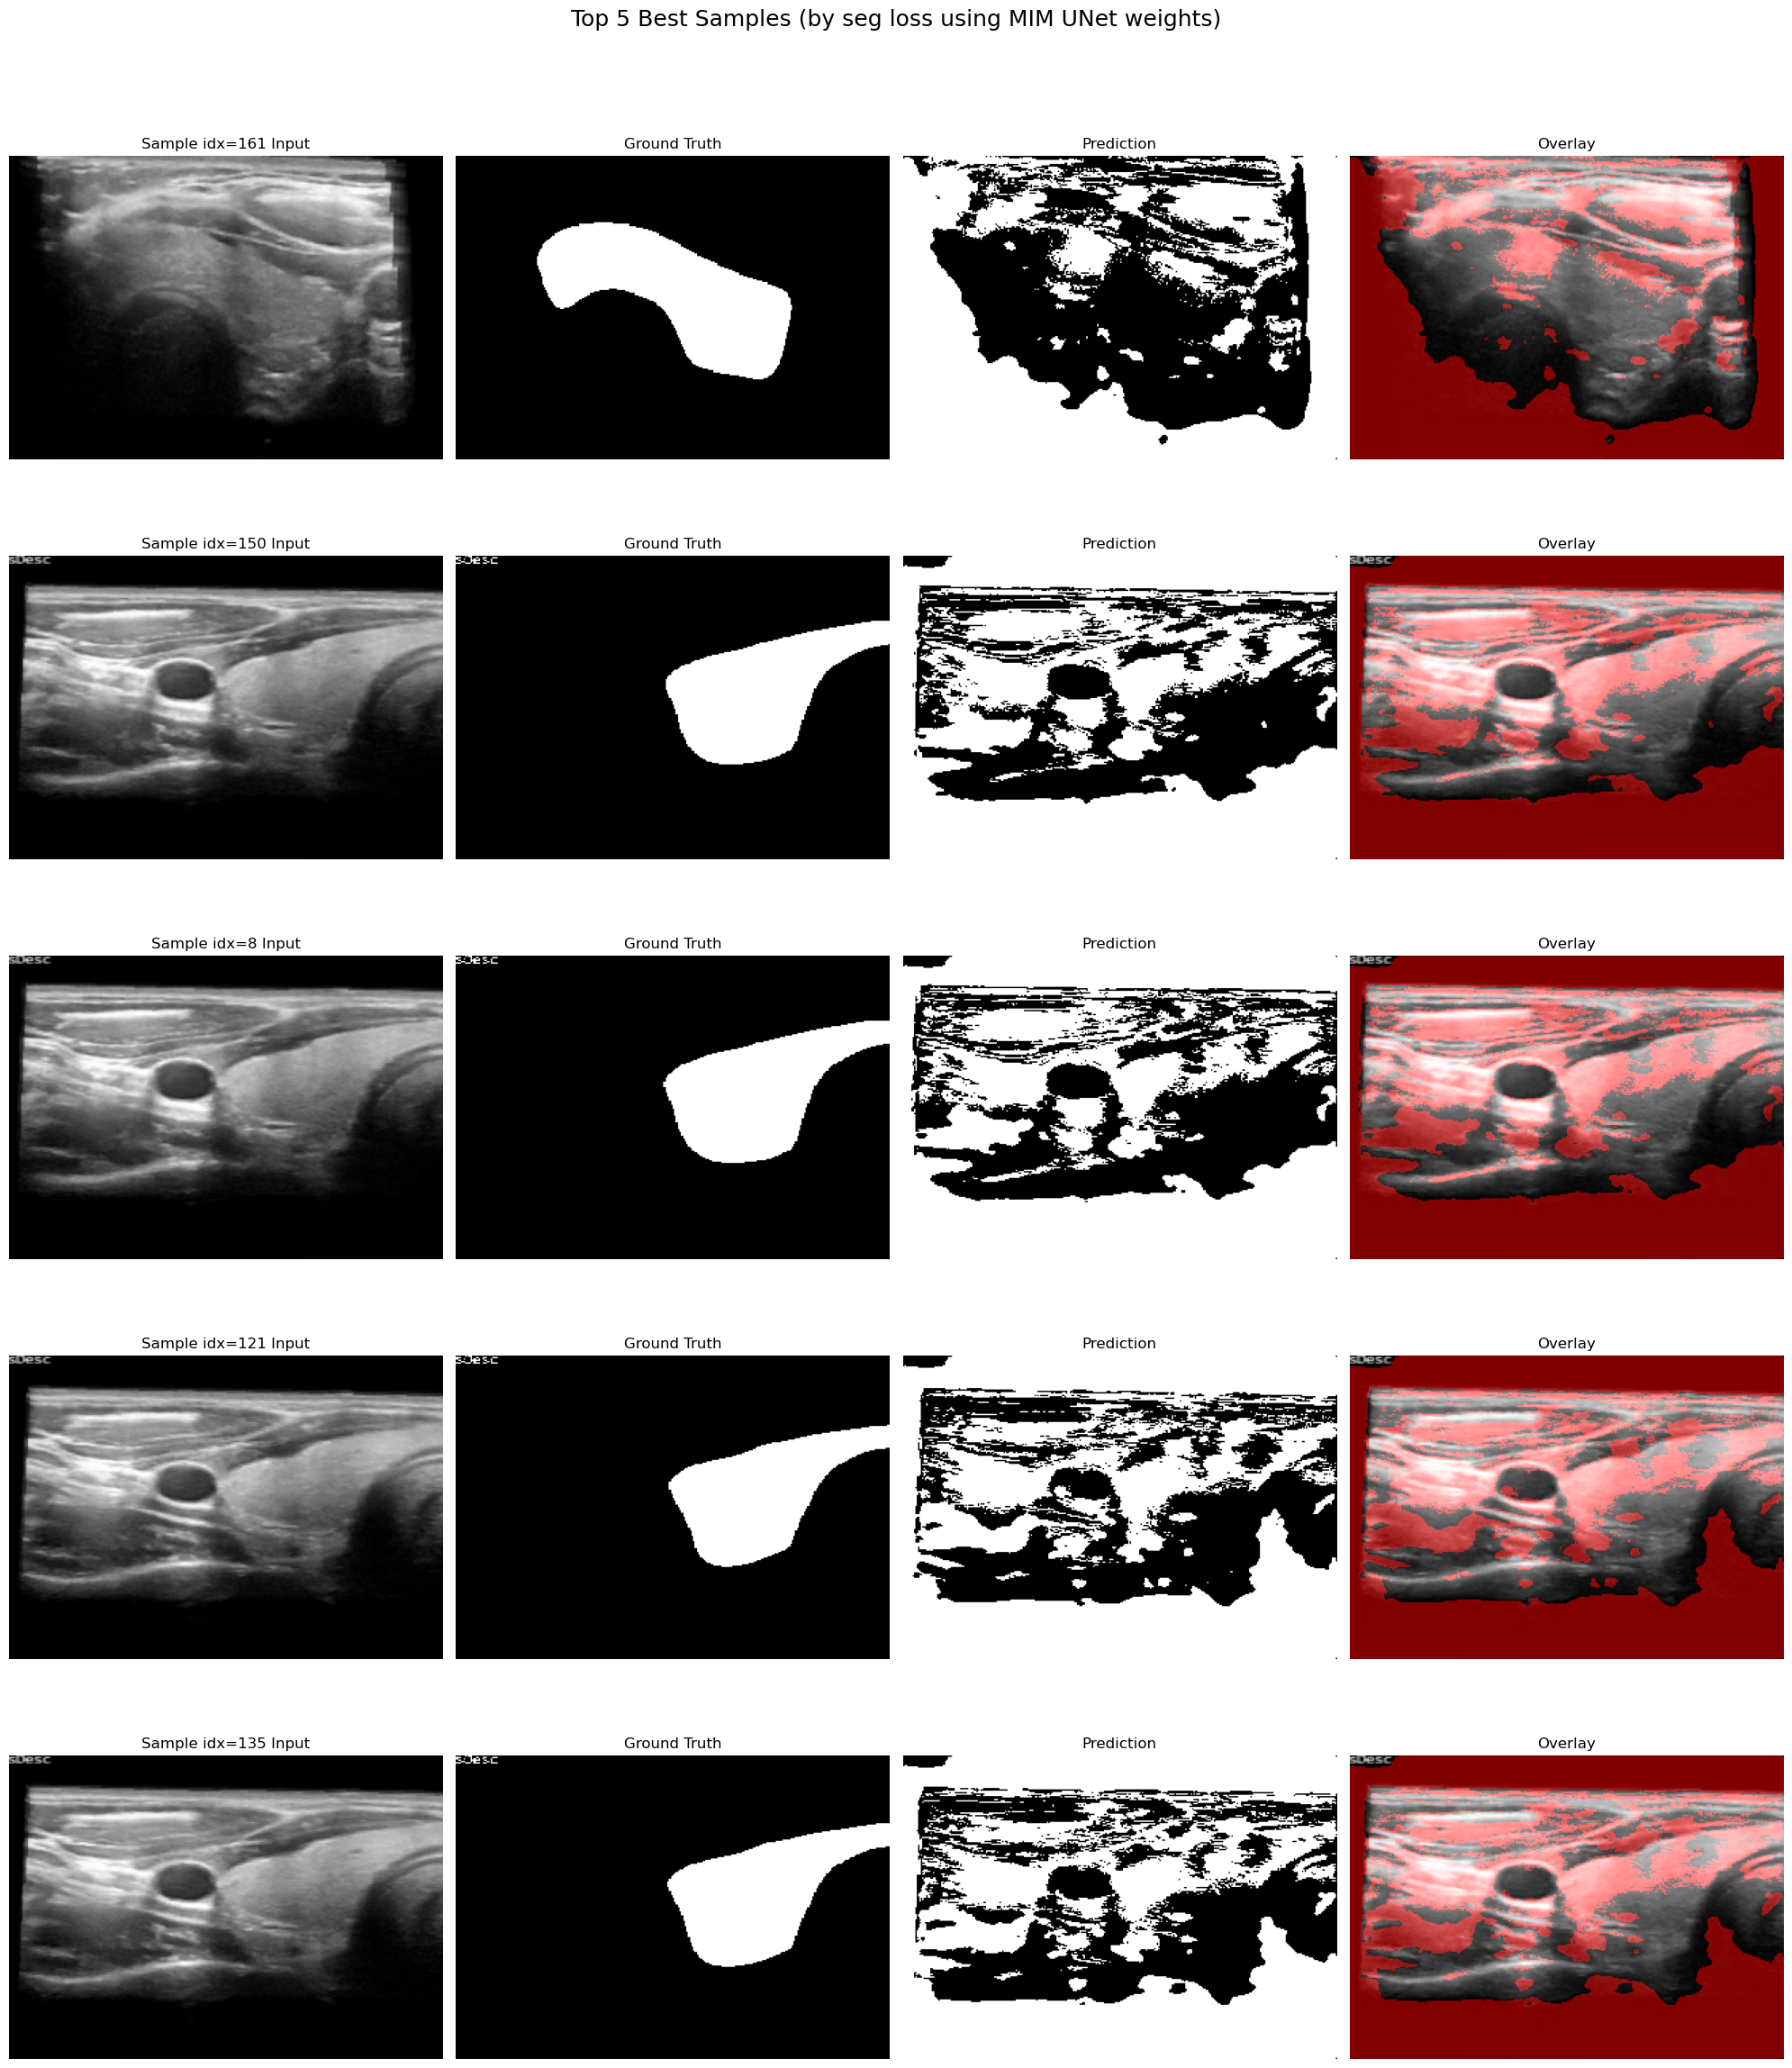

In [13]:
visualize_samples_in_one_plot(
    ds=val_ds,
    model=model,
    sample_indices=best_indices,
    title_prefix="Top 5 Best Samples (by seg loss using MIM UNet weights)"
)

In [39]:
visualize_samples_in_one_plot(
    ds=val_ds,
    model=model,
    sample_indices=worst_indices,
    title_prefix="Top 5 Worst Samples (by seg loss using MIM UNet weights)"
)

# ## MIM Reconstruction Visualization
#
# Extracted from Dental/MIM_Pretrain.ipynb


# ## TG3K MIM Reconstruction Visualization
#
# Visualizing reconstructed patches for the TG3K dataset.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils import (
    build_ultrasound_transform,
    TG3KMaskedReconstructionDataset,
    get_image_paths,
    create_unet_model,
)

# Paths
DATA_ROOT = Path("./tg3k/tg3k").resolve()
IMAGES_DIR = DATA_ROOT / "thyroid-image"
CHECKPOINT_PATH = Path("./tg3k/checkpoints_unet_mim/mim_best.pth").resolve()

print("IMAGES_DIR     :", IMAGES_DIR)
print("CHECKPOINT_PATH:", CHECKPOINT_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


IMAGES_DIR     : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image
CHECKPOINT_PATH: E:\Data\ToothSeg\tg3k\checkpoints_unet_mim\mim_best.pth
Device: cuda


In [8]:
# Dataset
transform = build_ultrasound_transform(height=224, width=320)
image_paths = get_image_paths(IMAGES_DIR)
print(f"Found {len(image_paths)} images.")

# Use TG3KMaskedReconstructionDataset
mim_dataset = TG3KMaskedReconstructionDataset(
    image_paths=image_paths,
    transform=transform,
    mask_ratio=0.3,
    min_block_size=32,
    max_block_size=96,
)
print("MIM Dataset ready:", len(mim_dataset))

# Model
# Assuming 'unet' model type based on checkpoint path 'checkpoints_unet_mim'
model_mim = create_unet_model(
    model_type="unet",
    in_channels=1,
    out_channels=1,
    base_channels=32,
    bilinear=True,
    device=device,
)

if CHECKPOINT_PATH.exists():
    state = torch.load(CHECKPOINT_PATH, map_location=device)
    if isinstance(state, dict) and "model_state_dict" in state:
        model_mim.load_state_dict(state["model_state_dict"])
    else:
        model_mim.load_state_dict(state)
    print("Loaded MIM weights from:", CHECKPOINT_PATH)
else:
    print(f"Checkpoint not found at {CHECKPOINT_PATH}")

model_mim.eval()


Found 3585 images.
MIM Dataset ready: 3585
Using standard UNet2D ...
Loaded MIM weights from: E:\Data\ToothSeg\tg3k\checkpoints_unet_mim\mim_best.pth


UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   


=== Reconstruction preview sample 267 ===
Image path : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image\0267.jpg


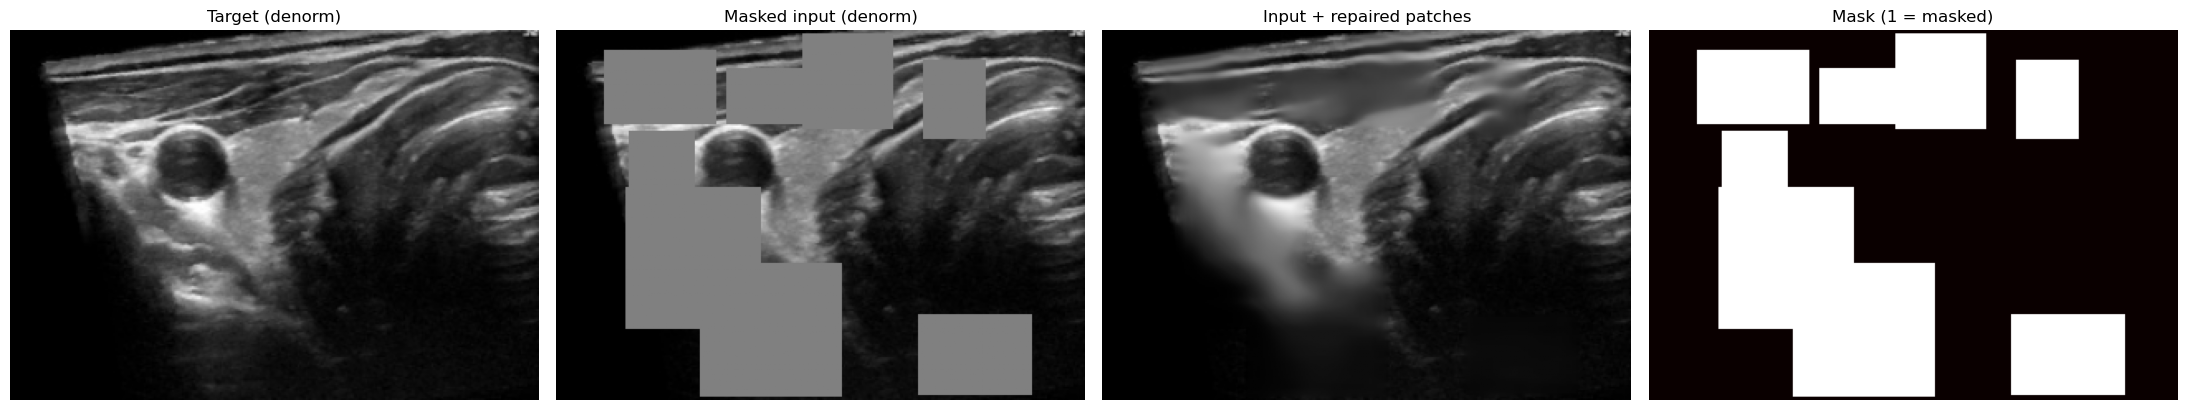


=== Reconstruction preview sample 3103 ===
Image path : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image\3103.jpg


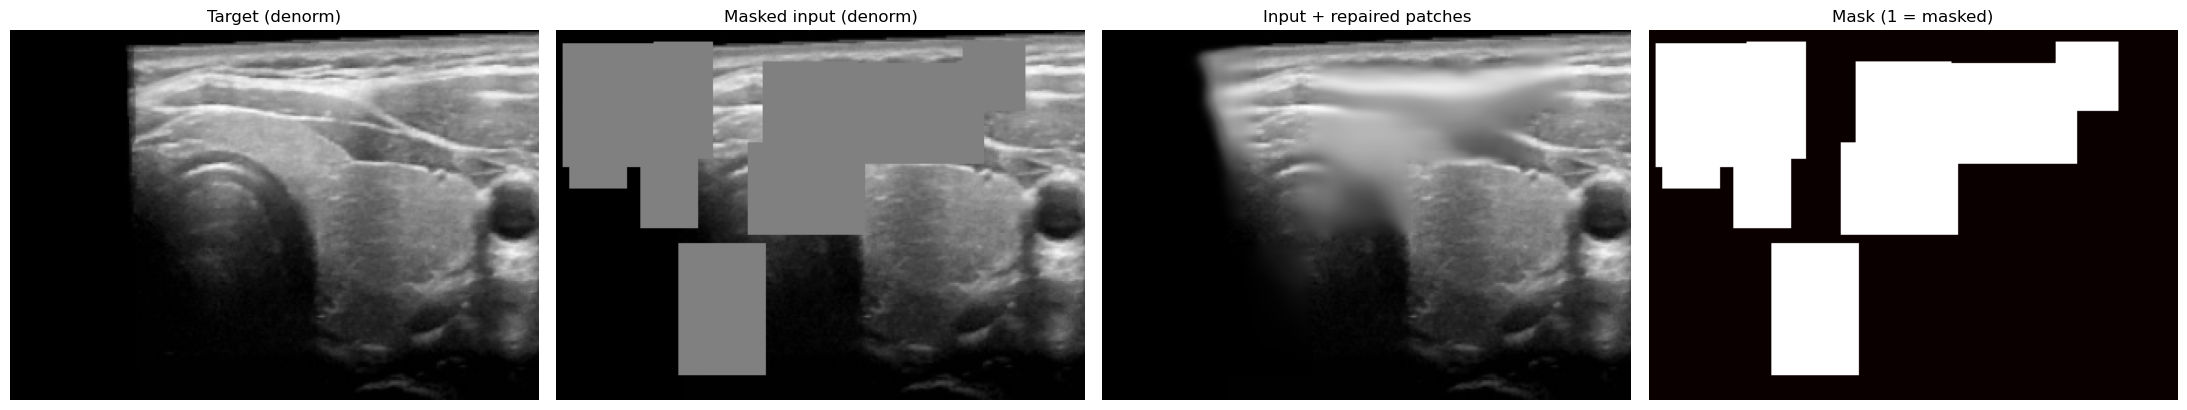


=== Reconstruction preview sample 2394 ===
Image path : E:\Data\ToothSeg\tg3k\tg3k\thyroid-image\2394.jpg


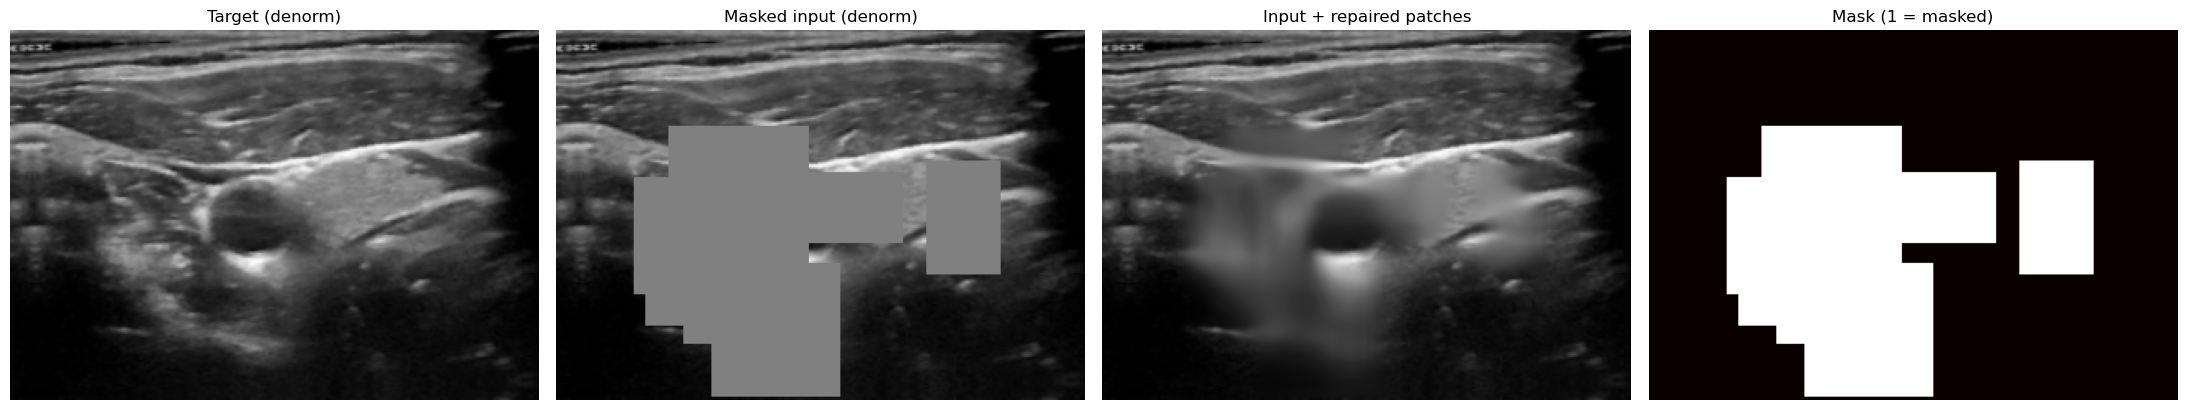

In [9]:
def denorm_np(x_np, mean=0.5, std=0.25):
    x = x_np * std + mean
    x = np.clip(x, 0.0, 1.0)
    return x

NUM_PREVIEW = 3
indices = np.random.choice(len(mim_dataset), NUM_PREVIEW, replace=False)

with torch.no_grad():
    for i in indices:
        masked_img, target_img, mask_tensor, meta = mim_dataset[i]

        masked_img_b = masked_img.unsqueeze(0).to(device)
        pred_b = model_mim(masked_img_b)

        pred_img  = pred_b.squeeze(0).squeeze(0).cpu().numpy()
        target_np = target_img.squeeze(0).cpu().numpy()
        masked_np = masked_img.squeeze(0).cpu().numpy()
        mask_np   = mask_tensor.squeeze(0).cpu().numpy()

        print(f"\n=== Reconstruction preview sample {i} ===")
        print("Image path :", meta["img_path"])

        # Combine
        combined_norm = masked_np + pred_img * mask_np
        combined_vis  = denorm_np(combined_norm)

        target_vis = denorm_np(target_np)
        masked_vis = denorm_np(masked_np)
        
        fig, axes = plt.subplots(1, 4, figsize=(22, 4))

        axes[0].imshow(target_vis, cmap="gray", vmin=0, vmax=1)
        axes[0].set_title("Target (denorm)")
        axes[0].axis("off")

        axes[1].imshow(masked_vis, cmap="gray", vmin=0, vmax=1)
        axes[1].set_title("Masked input (denorm)")
        axes[1].axis("off")

        axes[2].imshow(combined_vis, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Input + repaired patches")
        axes[2].axis("off")

        axes[3].imshow(mask_np, cmap="hot", vmin=0, vmax=1)
        axes[3].set_title("Mask (1 = masked)")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()


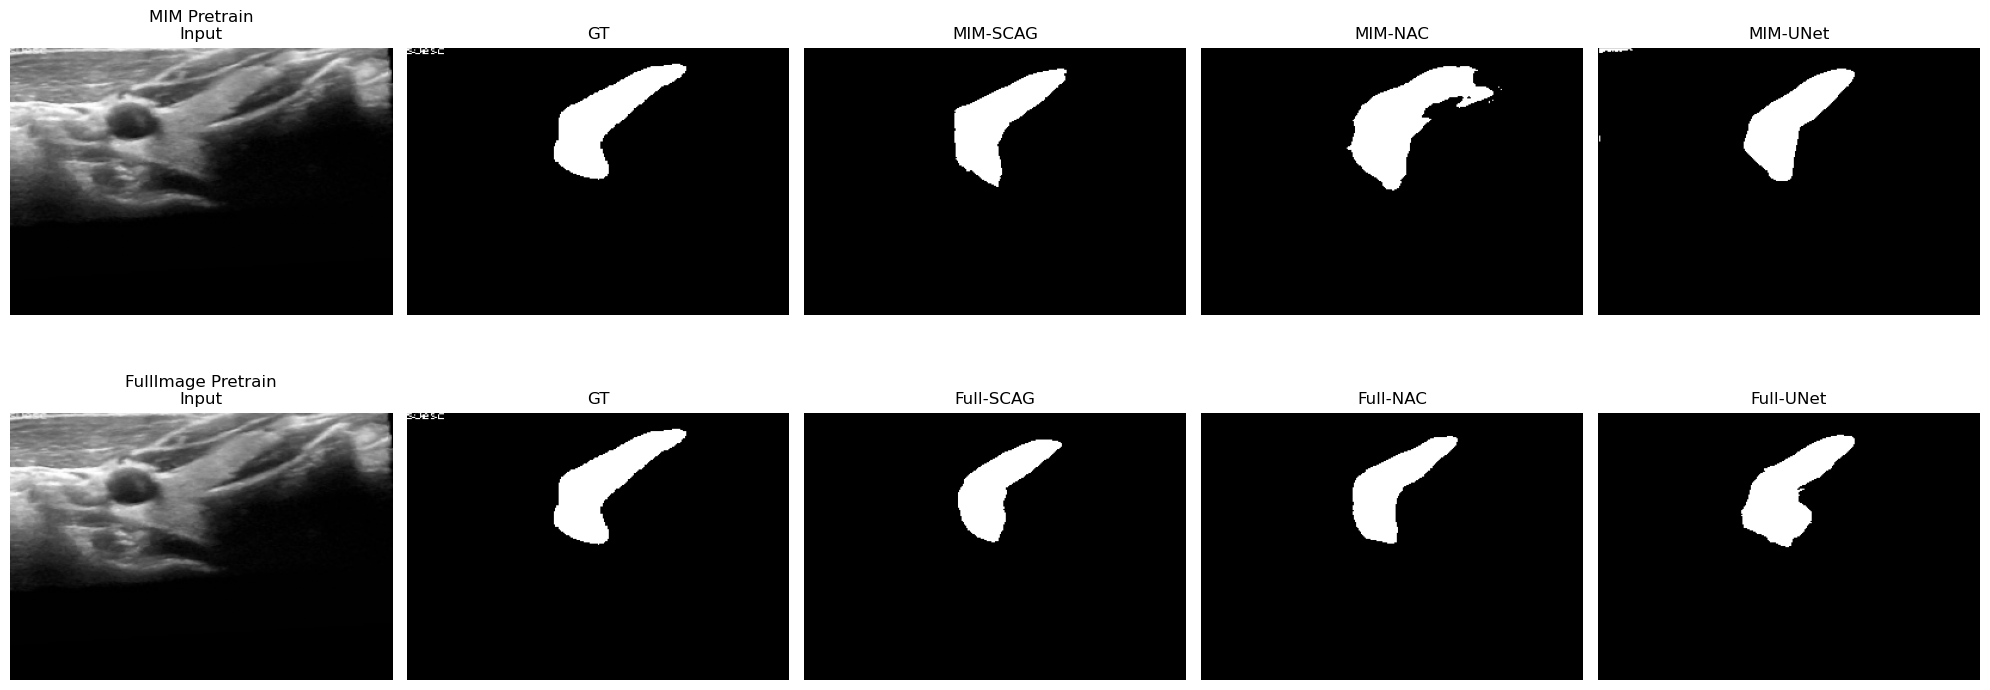

In [32]:
# Cell to visualize comparison of different models on the same image

import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tg3k_finetune_segementation import create_unet_model
from utils import load_image_as_array
import albumentations as A

# Configuration
SAMPLE_IDX = 15 # Using a known good sample
# You can change this index to see different images
# SAMPLE_IDX = 0

# Define model paths and types for Set 1 (MIM)
models_set1 = [
    {"name": "MIM-SCAG", "type": "unet", "path": "./tg3k/checkpoints_finetune/mim_unet/best_model.pth"},
    {"name": "MIM-NAC", "type": "scag", "path": "./tg3k/checkpoints_finetune/mim_scag/best_model.pth"},
    {"name": "MIM-UNet",  "type": "nac",  "path": "./tg3k/checkpoints_finetune/mim_nac/best_model.pth"},
]

# Define model paths and types for Set 2 (FullImage)
models_set2 = [
    {"name": "Full-SCAG", "type": "unet", "path": "./tg3k/checkpoints_finetune/fullimage_unet/best_model.pth"},
    {"name": "Full-NAC", "type": "scag", "path": "./tg3k/checkpoints_finetune/fullimage_scag/best_model.pth"},
    {"name": "Full-UNet",  "type": "nac",  "path": "./tg3k/checkpoints_finetune/fullimage_nac/best_model.pth"},
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_predict(model_type, ckpt_path, img_tensor):
    # Create model
    model = create_unet_model(
        model_type=model_type,
        in_channels=1,
        out_channels=1,
        base_channels=32,
        bilinear=True,
        device=device
    )
    
    # Load weights
    if os.path.exists(ckpt_path):
        state_dict = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print(f"Warning: Checkpoint not found at {ckpt_path}")
        return None

    model.eval()
    
    # Predict
    with torch.no_grad():
        img_batch = img_tensor.unsqueeze(0).to(device)
        logits = model(img_batch)
        probs = torch.sigmoid(logits)
        pred_mask = (probs > 0.5).float().squeeze().cpu().numpy()
        
    return pred_mask

# Get the sample image and mask
# Assuming val_ds is already defined in previous cells
if 'val_ds' not in locals():
    print("Error: val_ds is not defined. Please run the cell that defines val_ds first.")
else:
    img_t, mask_t, meta = val_ds[SAMPLE_IDX]
    img_path = Path(meta)
    
    # Load original image for display
    original_img_np = load_image_as_array(img_path)
    resize_transform = A.Resize(height=224, width=320)
    resized_img = resize_transform(image=original_img_np)["image"]
    
    gt_mask_np = mask_t.squeeze().cpu().numpy()

    # Prepare plot
    # We have 2 sets. Each set: Input, GT, Model1, Model2, Model3 -> 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Function to plot a row
    def plot_row(row_idx, models_list, title_prefix):
        # Input
        axes[row_idx, 0].imshow(resized_img, cmap="gray")
        axes[row_idx, 0].set_title(f"{title_prefix}\nInput")
        axes[row_idx, 0].axis("off")
        
        # GT
        axes[row_idx, 1].imshow(gt_mask_np, cmap="gray")
        axes[row_idx, 1].set_title("GT")
        axes[row_idx, 1].axis("off")
        
        # Models
        for i, m_info in enumerate(models_list):
            pred = load_and_predict(m_info["type"], m_info["path"], img_t)
            
            ax = axes[row_idx, i+2]
            if pred is not None:
                ax.imshow(pred, cmap="gray")
                ax.set_title(m_info["name"])
            else:
                ax.text(0.5, 0.5, "Ckpt Missing", ha='center')
            ax.axis("off")

    # Plot Set 1
    plot_row(0, models_set1, "MIM Pretrain")
    
    # Plot Set 2
    plot_row(1, models_set2, "FullImage Pretrain")
    
    plt.tight_layout()
    plt.show()
